In [294]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from awkde import GaussianKDE
from carl.learning.calibration import NDHistogramCalibrator, HistogramCalibrator
from carl.distributions.base import weighted_quantile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# Benchmarks
theta_score = 0
theta1 = 708
theta = 9

# Data
data_dir = '../data'

thetas = np.load(data_dir + '/thetas/thetas_parameterized.npy')
delta_theta = thetas[theta] - thetas[theta_score]
print(delta_theta)

X_train = np.load(data_dir + '/unweighted_events/X_train_scoreregression.npy')
scores_train = np.load(data_dir + '/unweighted_events/scores_train_scoreregression.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')[::10]
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')[:,::10]

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')
scores_test = np.load(data_dir + '/unweighted_events/scores_test.npy')[0]
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[theta]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
X_calibration_transformed = scaler.transform(X_calibration)

[-0.5 -0.5]


In [258]:
def s(r):
    return 1./(1. + r)

def r(s, epsilon=1.e-3):
    return (1.-s)/(s + epsilon)

# Score regression

In [12]:
def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def make_regressor(n_hidden_layers=3,
                    hidden_layer_size=100,
                    activation='tanh',
                    dropout_prob=0.0):
    # Inputs
    input_layer = Input(shape=(42,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    score_layer = Dense(2, activation='linear')(hidden_layer)

    # Combine outputs
    model = Model(inputs=[input_layer], outputs=[score_layer])

    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [13]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                      epochs=20, verbose=1, validation_split=0.2,
                      callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, scores_train)

Train on 7999812 samples, validate on 1999953 samples
Epoch 1/20
7999812/7999812 [==============================] - 305s 38us/step - loss: 0.0331 - val_loss: 0.0227
Epoch 2/20
7999812/7999812 [==============================] - 307s 38us/step - loss: 0.0193 - val_loss: 0.0190
Epoch 3/20
7999812/7999812 [==============================] - 327s 41us/step - loss: 0.0172 - val_loss: 0.0163
Epoch 4/20
7999812/7999812 [==============================] - 328s 41us/step - loss: 0.0160 - val_loss: 0.0165
Epoch 5/20
7999812/7999812 [==============================] - 326s 41us/step - loss: 0.0153 - val_loss: 0.0120
Epoch 6/20
7999812/7999812 [==============================] - 329s 41us/step - loss: 0.0148 - val_loss: 0.0186
Epoch 7/20
7999812/7999812 [==============================] - 333s 42us/step - loss: 0.0142 - val_loss: 0.0148
Epoch 8/20
7999812/7999812 [==============================] - 363s 45us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 00008: early stopping


In [14]:
that_calibration = regr.predict(X_calibration_transformed)

99955/99955 [==============================] - 1s 13us/step


# Calibration: KDE

In [15]:
pdf_nom = GaussianKDE()
print(that_calibration[::].shape)
print(weights_calibration[theta,::].shape)
pdf_nom.fit(that_calibration[::], weights=weights_calibration[theta,::])

pdf_den = GaussianKDE()
pdf_den.fit(that_calibration[::], weights=weights_calibration[theta1,::])

(99955, 2)
(99955,)


(array([0.6805552, 0.3685268], dtype=float32),
 array([[11.7820722 ,  1.74656082],
        [ 1.74656082,  6.87443276]]))

In [16]:
xi = np.linspace(-2.0, 2.0, 100)
yi = np.linspace(-2.0, 2.0, 100)
xx, yy = np.meshgrid(xi, yi)
scores_eval = np.asarray((xx.flatten(), yy.flatten())).T

In [17]:
p_nom_eval = pdf_nom.predict(scores_eval)
p_den_eval = pdf_den.predict(scores_eval)
ratio_eval = p_nom_eval / p_den_eval

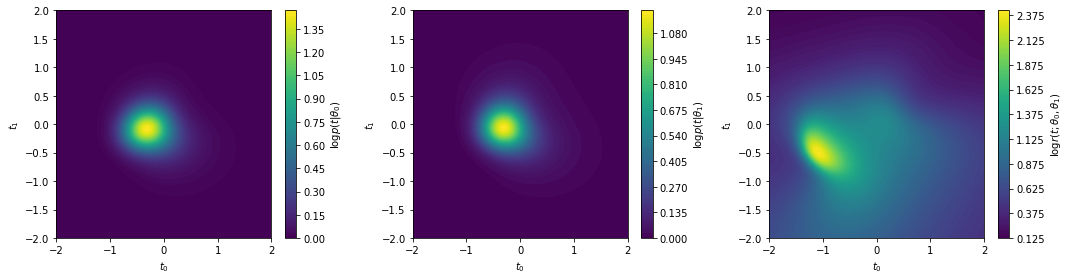

In [18]:
plt.figure(figsize=(15.,4.))



plt.subplot(1,3,1)
cs = plt.contourf(xi, yi, (p_nom_eval).reshape((100, 100)), 100, cmap="viridis")
cbar = plt.colorbar()
plt.xlabel('$t_0$')
plt.ylabel('$t_1$')
cbar.set_label(r'$\log \hat{p}(t|\theta_0)$')



plt.subplot(1,3,2)
cs = plt.contourf(xi, yi, (p_den_eval).reshape((100, 100)), 100, cmap="viridis")
cbar = plt.colorbar()
plt.xlabel('$t_0$')
plt.ylabel('$t_1$')
cbar.set_label(r'$\log \hat{p}(t|\theta_1)$')



plt.subplot(1,3,3)
cs = plt.contourf(xi, yi, (ratio_eval).reshape((100, 100)), 100, cmap="viridis")
cbar = plt.colorbar()
plt.xlabel('$t_0$')
plt.ylabel('$t_1$')
cbar.set_label(r'$\log \hat{r}(t; \theta_0, \theta_1)$')


plt.tight_layout()
plt.show()

# Calibration: 2d histogram

In [288]:
that_calibration_carlinput = np.vstack((that_calibration, that_calibration))
y_calibration_carlinput = np.hstack((np.zeros(that_calibration.shape[0]), np.ones(that_calibration.shape[0])))
w_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

xbins = np.concatenate(([-1000.,-4.,-3.,-2.5],
                        np.linspace(-2.,-0.6,8),
                        np.linspace(-0.5,0.5,11),
                        np.linspace(0.6,2.0,8),
                        [2.5,3.,4.,6.,8.,10.,20.,1000.]))
xrange = np.array((-1000.,1000.))

calibrator = NDHistogramCalibrator(bins=(xbins,xbins), range=(xrange,xrange))
calibrator.fit(that_calibration_carlinput, y_calibration_carlinput,
              sample_weight=w_calibration_carlinput)

NDHistogramCalibrator(bins=(array([-1.0e+03, -4.0e+00, -3.0e+00, -2.5e+00, -2.0e+00, -1.8e+00,
       -1.6e+00, -1.4e+00, -1.2e+00, -1.0e+00, -8.0e-01, -6.0e-01,
       -5.0e-01, -4.0e-01, -3.0e-01, -2.0e-01, -1.0e-01,  0.0e+00,
        1.0e-01,  2.0e-01,  3.0e-01,  4.0e-01,  5.0e-01,  6.0e-01,
        8.0e-01,  1.0e+00,...   2.0e+00,  2.5e+00,  3.0e+00,  4.0e+00,  6.0e+00,  8.0e+00,
        1.0e+01,  2.0e+01,  1.0e+03])),
           eps=0.1,
           range=(array([-1000.,  1000.]), array([-1000.,  1000.])))

In [289]:
xi = np.linspace(-5.0, 10.0, 200)
yi = np.linspace(-5.0, 10.0, 200)

xx, yy = np.meshgrid(xi, yi)
scores_eval = np.asarray((xx.flatten(), yy.flatten())).T

r_eval = r(calibrator.predict(scores_eval)).reshape((200,200))

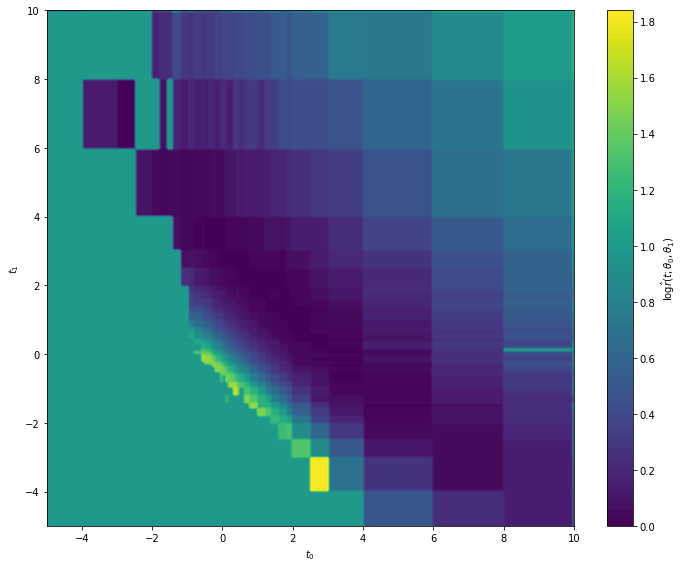

In [290]:
plt.figure(figsize=(10.,8.))

cs = plt.contourf(xi, yi, r_eval, 100, cmap="viridis")
cbar = plt.colorbar()
plt.xlabel('$t_0$')
plt.ylabel('$t_1$')
cbar.set_label(r'$\log \hat{r}(t; \theta_0, \theta_1)$')

plt.tight_layout()
plt.show()

# 1-dim histogram of theta times score

In [420]:
from carl.learning.calibration import HistogramCalibrator

tt_calibration = that_calibration.dot(delta_theta)

tt_calibration_carlinput = np.hstack((tt_calibration, tt_calibration))
y_calibration_carlinput = np.hstack((np.zeros(tt_calibration.shape[0]), np.ones(tt_calibration.shape[0])))
w_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

calibrator = HistogramCalibrator(bins=500)#, range=tt_range)
calibrator.fit(tt_calibration_carlinput, y_calibration_carlinput,
               sample_weight=w_calibration_carlinput)

HistogramCalibrator(bins=500, eps=0.1, independent_binning=False,
          interpolation=None, range=None, variable_width=False)

In [421]:
xi = np.linspace(-5.0, 10.0, 200)
yi = np.linspace(-5.0, 10.0, 200)

xx, yy = np.meshgrid(xi, yi)
tt_eval = np.asarray((xx.flatten(), yy.flatten())).T.dot(delta_theta)

r_eval = r(calibrator.predict(tt_eval)).reshape((200,200))

print(np.all(np.isfinite(r_eval)))

True


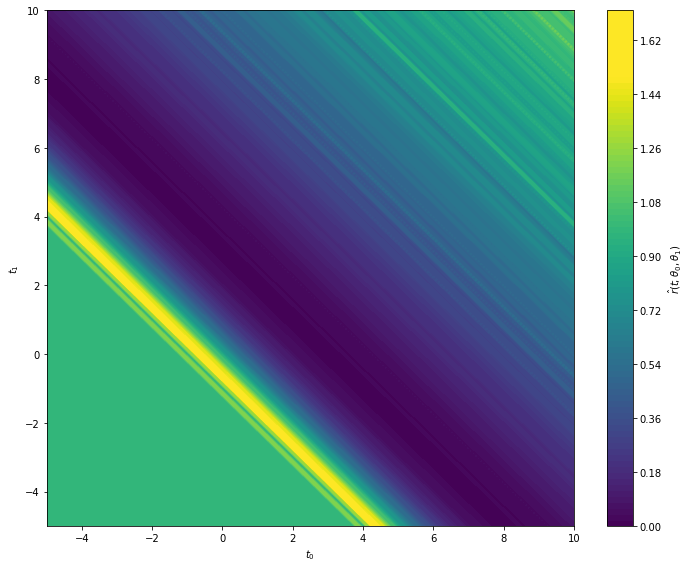

In [422]:
plt.figure(figsize=(10.,8.))

cs = plt.contourf(xi, yi, r_eval, 100, vmin=0.,vmax=1.5, cmap="viridis")
cbar = plt.colorbar()
plt.xlabel('$t_0$')
plt.ylabel('$t_1$')
cbar.set_label(r'$\hat{r}(t; \theta_0, \theta_1)$')

plt.tight_layout()
plt.show()

# Performance on test sample

In [423]:
# Score regression
scores_hat_test = regr.predict(X_test_transformed)
tt_hat_test = scores_hat_test.dot(delta_theta)

48238/48238 [==============================] - 1s 12us/step


In [424]:
# KDE in score space
# p_nom_test = pdf_nom.predict(scores_hat_test)
# p_den_test = pdf_den.predict(scores_hat_test)
# r_hat_test = p_nom_test / p_den_test

# 2d Histogram
# r_hat_test = r(calibrator.predict(scores_hat_test))

# 1d t.theta histogram
r_hat_test = r(calibrator.predict(tt_hat_test))

# Sanitize result
r_hat_test[np.invert(np.isfinite(np.log(r_hat_test)))] = 1.

In [425]:
# MSE
print(mean_squared_error(np.log(r_test), np.log(r_hat_test)))

cut = np.invert(r_hat_test==1.)
print(mean_squared_error(np.log(r_test[cut]), np.log(r_hat_test[cut])))

0.008183744691929248
0.008183744691929248


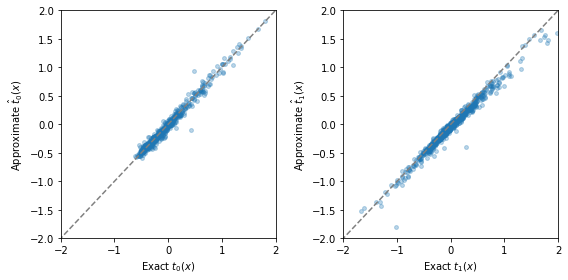

In [426]:
plt.figure(figsize=(8,4))



plt.subplot(1,2,1)

plt.plot((-100.,100.),(-100.,100.), c='0.5', ls='--')
plt.scatter(scores_test[::50,0], scores_hat_test[::50,0],
            alpha=0.3, s=15.)

plt.xlim(-2.,2.)
plt.ylim(-2.,2.)

plt.xlabel('Exact $t_0(x)$')
plt.ylabel('Approximate $\hat{t}_0(x)$')



plt.subplot(1,2,2)

plt.plot((-100.,100.),(-100.,100.), c='0.5', ls='--')
plt.scatter(scores_test[::50,1], scores_hat_test[::50,1],
            alpha=0.3, s=15.)

plt.xlim(-2.,2.)
plt.ylim(-2.,2.)

plt.xlabel('Exact $t_1(x)$')
plt.ylabel('Approximate $\hat{t}_1(x)$')

plt.tight_layout()
plt.show()

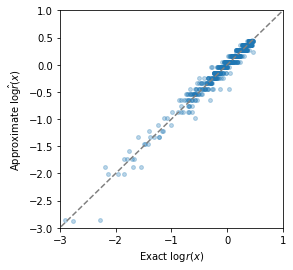

In [427]:
plt.figure(figsize=(4,4))

plt.plot((-100.,100.),(-100.,100.), c='0.5', ls='--')
plt.scatter(np.log(r_test)[::50], np.log(r_hat_test)[::50],
            alpha=0.3, s=15.)

plt.xlim(-3.,1.)
plt.ylim(-3.,1.)

plt.xlabel('Exact $\log r(x)$')
plt.ylabel('Approximate $\log \hat{r}(x)$')

plt.show()

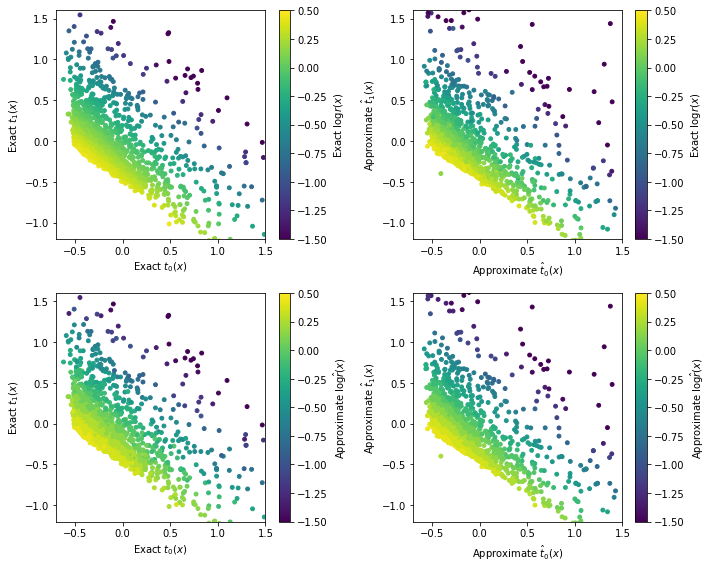

In [428]:
plt.figure(figsize=(10.,8.))



plt.subplot(2,2,1)
plt.scatter(scores_test[::25,0], scores_test[::25,1],
            c=np.log(r_test)[::25],
            vmin=-1.5, vmax=0.5,
            alpha=1., s=15.)
cbar = plt.colorbar()
plt.xlim(-0.7,1.5)
plt.ylim(-1.2,1.6)
plt.xlabel('Exact $t_0(x)$')
plt.ylabel('Exact $t_1(x)$')
cbar.set_label(r'Exact $\log r(x)$')



plt.subplot(2,2,2)
plt.scatter(scores_hat_test[::25,0], scores_hat_test[::25,1],
            c=np.log(r_test)[::25],
            vmin=-1.5, vmax=0.5,
            alpha=1., s=15.)
cbar = plt.colorbar()
plt.xlim(-0.7,1.5)
plt.ylim(-1.2,1.6)
plt.xlabel('Approximate $\hat{t}_0(x)$')
plt.ylabel('Approximate $\hat{t}_1(x)$')
cbar.set_label(r'Exact $\log r(x)$')



plt.subplot(2,2,3)
plt.scatter(scores_test[::25,0], scores_test[::25,1],
            c=np.log(r_hat_test)[::25],
            vmin=-1.5, vmax=0.5,
            alpha=1., s=15.)
cbar = plt.colorbar()
plt.xlim(-0.7,1.5)
plt.ylim(-1.2,1.6)
plt.xlabel('Exact $t_0(x)$')
plt.ylabel('Exact $t_1(x)$')
cbar.set_label(r'Approximate $\log \hat{r}(x)$')



plt.subplot(2,2,4)
plt.scatter(scores_hat_test[::25,0], scores_hat_test[::25,1],
            c=np.log(r_hat_test)[::25],
            vmin=-1.5, vmax=0.5,
            alpha=1., s=15.)
cbar = plt.colorbar()
plt.xlim(-0.7,1.5)
plt.ylim(-1.2,1.6)
plt.xlabel('Approximate $\hat{t}_0(x)$')
plt.ylabel('Approximate $\hat{t}_1(x)$')
cbar.set_label(r'Approximate $\log \hat{r}(x)$')



plt.tight_layout()
plt.show()

# Local model experiments

In [ ]:
pdf_sm= GaussianKDE()
pdf_sm.fit(that_calibration[::], weights=weights_calibration[0,::])

In [ ]:
p_sm_test = pdf_sm.predict(scores_hat_test)

In [ ]:
print(scores_hat_test.shape, p_sm_test.shape)

In [ ]:
p_nom_local_test = p_sm_test * np.exp(scores_hat_test)
p_nom_local_test / 